In [1]:
# IMPORTS

# data manipulation and analysis
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# warings
import warnings
warnings.filterwarnings('ignore')

# set random seed for reproducibility
np.random.seed(42)

#### 1. Data Loading

In [3]:
# loading the train set
train_df = pd.read_csv('../Data/breast_cancer_trainset.csv')

X_train = train_df.drop(columns=['diagnosis'])
y_train = train_df['diagnosis']

# Data dimensions
print("Data Dimensions:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# Target distribution
print("-"*60)
print("Target Distribution:")
print(f"Benign (0): {(y_train==0).sum()} samples ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Malignant (1): {(y_train==1).sum()} samples ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"Total: {len(y_train)} samples")
print("-"*60)
print("-"*60)

Data Dimensions:
X_train: (455, 30)
y_train: (455,)
------------------------------------------------------------
Target Distribution:
Benign (0): 285 samples (62.6%)
Malignant (1): 170 samples (37.4%)
Total: 455 samples
------------------------------------------------------------
------------------------------------------------------------


#### 2. Baseline XGBoost Model (Default Parameters)

We create a baseline model with default XGBoost hyperparameters. This serves as a starting point before hyperparameter optimization. Since we're using GridSearchCV with cross-validation for tuning, we don't evaluate the baseline separately. The cross-validation process will determine optimal parameters across the entire training set.

In [5]:
# Baseline XGBoost Model (Default Parameters)
# Create a baseline model to understand default performance before hyperparameter tuning

xgb_baseline = Pipeline([
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Train on full training data
xgb_baseline.fit(X_train, y_train)

print("=" * 60)
print("BASELINE MODEL TRAINING COMPLETE")
print("=" * 60)
print("Model: XGBoost with default hyperparameters")
print(f"Training samples: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print("=" * 60)
print("\nBaseline model established.")

BASELINE MODEL TRAINING COMPLETE
Model: XGBoost with default hyperparameters
Training samples: 455
Features: 30

Baseline model established.


#### 3. Hyperparameter Tuning with GridSearchCV and Cross-Validation

We use GridSearchCV with 5-fold StratifiedKFold cross-validation to find the optimal hyperparameters for XGBoost. GridSearchCV automatically splits the training data into folds, trains models on different hyperparameter combinations, and validates performance on held-out folds. This embedded validation process eliminates the need for a separate validation set, allowing us to use all 455 samples efficiently. We optimize for recall as the scoring metric because minimizing false negatives (missed cancer diagnoses) is critical in medical applications, meaning it's better to have false positives (unnecessary follow-ups) than to miss malignant cases.

In [6]:
# Create pipeline for hyperparameter tuning
xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Parameter grid
param_grid_pipeline = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__gamma': [0, 0.1, 0.2]
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with pipeline
grid_search_pipeline = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_pipeline,
    cv=cv_strategy,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)

# Fit on raw training data
grid_search_pipeline.fit(X_train, y_train)

print(f"Best parameters: {grid_search_pipeline.best_params_}")
print(f"Best Cross-Validation Recall Score: {grid_search_pipeline.best_score_:.4f}")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.1s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.1s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.1s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.0s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.1s
[CV] END xgb__colsample_bytree=0.8, 

#### 4. Best Model Results from GridSearchCV

GridSearchCV has completed hyperparameter tuning using 5-fold cross-validation. The best model was selected based on the highest average recall score across all folds. Below we display the optimal hyperparameters and cross-validation performance. This model will be saved for final evaluation on the test set after comparing with the other three models (SVM, Logistic Regression, Neural Network).

In [7]:
# Extract best model from GridSearchCV
xgb_best_model = grid_search_pipeline.best_estimator_

# Display best hyperparameters
print("=" * 70)
print("BEST MODEL FROM GRIDSEARCHCV")
print("=" * 70)
print("\nBest Hyperparameters:")
for param, value in grid_search_pipeline.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Recall Score: {grid_search_pipeline.best_score_:.4f}")
print("\n" + "=" * 70)

# Display CV results summary
cv_results_df = pd.DataFrame(grid_search_pipeline.cv_results_)
top_5_models = cv_results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print("\nTop 5 Hyperparameter Combinations (by Recall):")
print("-" * 70)
for idx, row in top_5_models.iterrows():
    print(f"\nRank {top_5_models.index.get_loc(idx) + 1}:")
    print(f"  Recall: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")

print("\n" + "=" * 70)
print("Model is ready for final test set evaluation.")
print("=" * 70)

BEST MODEL FROM GRIDSEARCHCV

Best Hyperparameters:
  xgb__colsample_bytree: 0.8
  xgb__gamma: 0
  xgb__learning_rate: 0.3
  xgb__max_depth: 5
  xgb__min_child_weight: 1
  xgb__n_estimators: 200
  xgb__subsample: 1.0

Best Cross-Validation Recall Score: 0.9588


Top 5 Hyperparameter Combinations (by Recall):
----------------------------------------------------------------------

Rank 1:
  Recall: 0.9588 (±0.0235)
  Params: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}

Rank 2:
  Recall: 0.9588 (±0.0235)
  Params: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 300, 'xgb__subsample': 1.0}

Rank 3:
  Recall: 0.9588 (±0.0235)
  Params: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 7, 'xgb__min_child_weight': 1, 'xgb__n_est

#### 5. Feature Importance Analysis

##### Now that we have trained the best model on the full training set, we can analyze the feature importance.


Top 10 Features by Importance:
                 Feature  Importance
20          radius_worst    0.306232
7    concave points_mean    0.233277
22       perimeter_worst    0.107496
27  concave points_worst    0.073902
25     compactness_worst    0.066626
23            area_worst    0.031805
26       concavity_worst    0.023347
1           texture_mean    0.023275
3              area_mean    0.020444
12          perimeter_se    0.017303


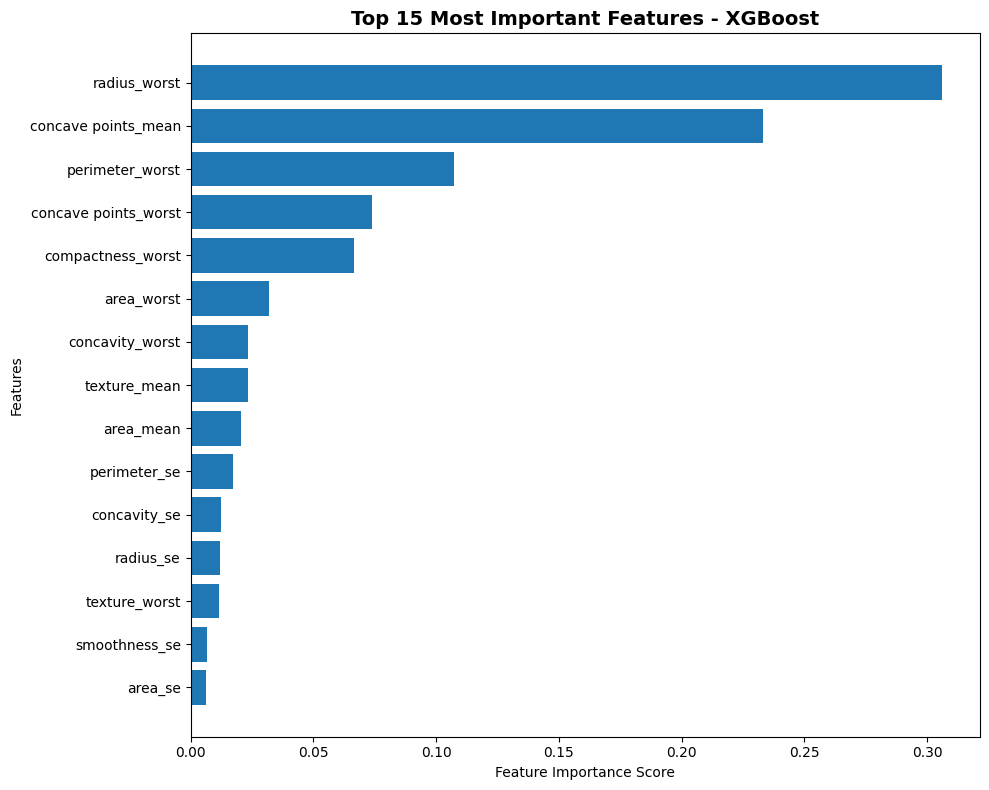

In [8]:
# Extract XGBoost model from pipeline and get feature importances
xgb_model = xgb_best_model.named_steps['xgb']
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 Features by Importance:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 15 Most Important Features - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 6. Summary and Model Selection

After comprehensive experimentation with XGBoost for breast cancer classification, we implemented a gradient boosting ensemble method with rigorous hyperparameter optimization. Using GridSearchCV with 5-fold StratifiedKFold cross-validation on our training dataset of 455 samples, we tested 972 hyperparameter combinations (4,860 total training runs) across seven key parameters: n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, and gamma. The grid search optimized for recall to minimize false negatives (missed cancers), which is critical in medical diagnosis where it's better to have false positives (unnecessary follow-ups) than to miss malignant cases. The best model achieved a cross-validation recall score of 0.9588 (±0.0235), with optimal hyperparameters: learning_rate=0.3, max_depth=5, n_estimators=200, subsample=1.0, colsample_bytree=0.8, min_child_weight=1, and gamma=0. Feature importance analysis revealed that `radius_worst`, `concave points`.